<a href="https://colab.research.google.com/github/chasubeen/python_selfstudy/blob/master/deep_pytorch/4.%20%EC%8B%AC%EC%B8%B5%20%EC%88%9C%ED%99%98%20%EC%8B%A0%EA%B2%BD%EB%A7%9D%20%EC%95%84%ED%82%A4%ED%85%8D%EC%B2%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **감성 분석을 위한 RNN 훈련하기**

## **텍스트 데이터셋 로딩 및 전처리**

### **1) Import Libraries**

In [ ]:
import os
import time
import numpy as np
from tqdm import tqdm
# 문자열 처리를 위한 라이브러리
from string import punctuation
from collections import Counter
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

torch.manual_seed(123)

### **2) 데이터 파일 불러오기**
- IMDB 감성 분석 데이터셋을 사용
  - 영화 리뷰 텍스트와 그에 해당하는 감성 레이블로 구성됨

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
### 텍스트 파일에서 리뷰 데이터와 감성 레이블 읽어오기

review_list = [] # Feature
label_list = [] # Target
for label in ['pos', 'neg']:
  for fname in tqdm(os.listdir(f'/content/drive/MyDrive/딥러닝 공부/실전! 파이토치 딥러닝 프로젝트/data/aclImdb/train/{label}/')):
    if 'txt' not in fname:
      continue
    with open(os.path.join(f'/content/drive/MyDrive/딥러닝 공부/실전! 파이토치 딥러닝 프로젝트/data/aclImdb/train/{label}/', fname), encoding="utf8") as f:
      review_list += [f.read()]
      label_list += [label]
print ('Number of reviews :', len(review_list))

100%|██████████| 12500/12500 [09:48<00:00, 21.22it/s] 

Number of reviews : 25000


### **3) 데이터 로딩**
- 텍스트 데이터 전처리
  - 먼저 전체 텍스트 말뭉치(corpus)를 소문자로 처리한 다음, 리뷰 텍스트에서 구두점을 모두 제거함
  - 그런 다음 전체 리뷰에 나오는 단어를 모두 모아 단어 등장 횟수를 계산하고 가장 많이 사용되는 단어를 확인하기 위해 단어 등장 횟수 기준으로 내림차순 정렬함


In [ ]:
# 리뷰 텍스트 전처리
review_list = [review.lower() for review in review_list]
review_list = [''.join([letter for letter in review if letter not in punctuation]) for review in tqdm(review_list)]

# 전체 리뷰 텍스트 축적
reviews_blob = ' '.join(review_list)

# 전체 리뷰에서 나오는 모든 단어를 리스트로 생성
review_words = reviews_blob.split()

# 단어 등장 횟수 가져오기
count_words = Counter(review_words)

# 등장 횟수로 단어 정렬(내림차순)
total_review_words = len(review_words)
sorted_review_words = count_words.most_common(total_review_words)

print(sorted_review_words[:10])

100%|██████████| 25000/25000 [00:01<00:00, 18041.40it/s]


[('the', 334691), ('and', 162228), ('a', 161940), ('of', 145326), ('to', 135042), ('is', 106855), ('in', 93028), ('it', 77099), ('i', 75719), ('this', 75190)]


- 가장 많이 등장하는 단어는 명사가 아닌 한정사, 대명사 같은 것들임
- 일반적으로 명사가 아닌 단어(불용어)는 많은 의미를 전달하지 않으므로 말뭉치에서 제거됨
  - 현재는 일단 제거하지 않고 넘어감

### **4) 인코딩**
- 머신러닝 모델은 단어가 아니라 숫자만 이해함
  - 개별 단어를 숫자 또는 토큰으로 변환하는 작업이 필요
  

**사전 구축**  
단어-정수 매핑 얻기

In [ ]:
# 텍스트를 숫자로 인코딩하기 위해 단러-정수(토큰) 딕셔너리를 생성

vocab_to_token = {word:idx + 1 for idx, (word, count) in enumerate(sorted_review_words)}
print(list(vocab_to_token.items())[:10])

[('the', 1), ('and', 2), ('a', 3), ('of', 4), ('to', 5), ('is', 6), ('in', 7), ('it', 8), ('i', 9), ('this', 10)]


- 가장 많이 등장하는 단어에 1을 시작으로 순서대로 단어에 숫자가 할당됨

**리뷰 -> 숫자**  
위에서 구축한 사전을 사용해 숫자 리스트로 변환

In [ ]:
reviews_tokenized = []

for review in review_list:
  word_to_token = [vocab_to_token[word] for word in review.split()]
  reviews_tokenized.append(word_to_token)

print(review_list[0])
print()
print(reviews_tokenized[0])

**긍정/부정**  
감성 분류값을 숫자로 인코딩하는 과정이 필요

In [ ]:
# 감성을 0 또는 1로 인코딩
encoded_label_list = [1 if label =='pos' else 0 for label in label_list]

reviews_len = [len(review) for review in reviews_tokenized]

reviews_tokenized = [reviews_tokenized[i] for i, l in enumerate(reviews_len) if l > 0 ]
encoded_label_list = np.array([encoded_label_list[i] for i, l in enumerate(reviews_len) if l> 0 ], dtype='float32')

### **5) 정규화**
- 리뷰가 다양하므로 길이 또한 다양할 수 있음
  - 그러나 모델은 고정된 길이가 입력되기를 기대함
- 다양한 길이의 리뷰를 정규화 해 모두 같은 길이를 갖도록 만들어줌
  - 시퀀스 길이 L(여기서는 512)을 정의한 다음 L보다 길이가 짧은 시퀀스에는 패딩을 가하고 L보다 긴 시퀀스는 잘라냄

In [ ]:
def pad_sequence(reviews_tokenized, sequence_length):
  ''' 0으로 패딩되거나 sequence_length에 맞춰 잘린, 토큰화된 리뷰 시퀀스를 반환
  '''
  padded_reviews = np.zeros((len(reviews_tokenized), sequence_length), dtype = int)

  for idx, review in enumerate(reviews_tokenized):
    review_len = len(review)

    if review_len <= sequence_length:
      zeroes = list(np.zeros(sequence_length - review_len))
      new_sequence = zeroes+review
    elif review_len > sequence_length:
      new_sequence = review[0:sequence_length]

    padded_reviews[idx,:] = np.array(new_sequence)

  return padded_reviews

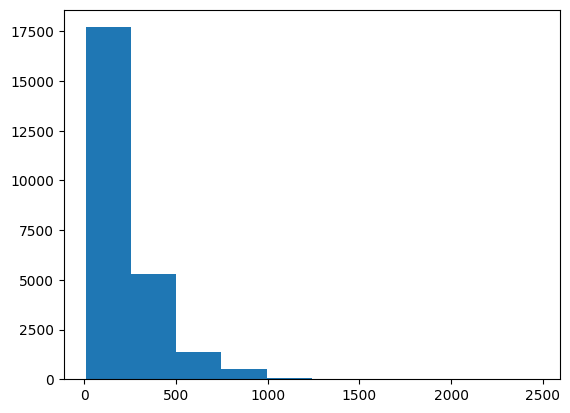

In [ ]:
sequence_length = 512 # 고정된 길이
padded_reviews = pad_sequence(reviews_tokenized=reviews_tokenized, sequence_length=sequence_length)

plt.hist(reviews_len);

- 대부분의 리뷰는 500 단어보다 짧은 것을 확인할 수 있음
- 모델에 사용할 시퀀스 길이로 512를 선택하고 정확히 512 단어 길이가 아닌 시퀀스를 그에 맞춰 수정

## **모델 훈련**

### **1) 데이터셋 분리**

In [ ]:
train_val_split = 0.75

# 훈련 데이터셋과 검증 데이터셋으로 분리
train_X = padded_reviews[:int(train_val_split*len(padded_reviews))]
train_y = encoded_label_list[:int(train_val_split*len(padded_reviews))]

validation_X = padded_reviews[int(train_val_split*len(padded_reviews)):]
validation_y = encoded_label_list[int(train_val_split*len(padded_reviews)):]

### **2) Dataset, DataLoader 정의**

In [ ]:
# torch 데이터셋 생성
train_dataset = TensorDataset(torch.from_numpy(train_X).to(device), torch.from_numpy(train_y).to(device))
validation_dataset = TensorDataset(torch.from_numpy(validation_X).to(device), torch.from_numpy(validation_y).to(device))

batch_size = 32

# 토치 데이터로더(데이터 shuffle)
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
validation_dataloader = DataLoader(validation_dataset, batch_size = batch_size, shuffle = True)

### **3) 데이터 시각화**
- 데이터 구성을 확인하기 위해 32개 리뷰와 그에 해당하는 감성 레이블을 하나의 배치로 하여 시각화

In [ ]:
# 훈련 데이터 배치 가져오기
train_data_iter = iter(train_dataloader)
X_example, y_example = next(train_data_iter)
print('Example Input size: ', X_example.size()) # batch_size, seq_length
print('Example Input:\n', X_example)
print()
print('Example Output size: ', y_example.size()) # batch_size
print('Example Output:\n', y_example)

Example Input size:  torch.Size([32, 512])
Example Input:
 tensor([[    0,     0,     0,  ...,    27,     3,   861],
        [    0,     0,     0,  ...,    72,  6945,   309],
        [    0,     0,     0,  ...,    23,    37,  4482],
        ...,
        [    0,     0,     0,  ...,   235,    35,  8111],
        [    0,     0,     0,  ...,     8,     6,  4982],
        [    0,     0,     0,  ..., 16680,   147,   597]])

Example Output size:  torch.Size([32])
Example Output:
 tensor([0., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 0.,
        0., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1.])


## **모델 인스턴스화 및 훈련**

### **1) 래퍼 RNN 클래스 정의**
- 임베딩 계층으로 시작해 RNN 계층, 마지막으로 완전 연결 계층으로 이어지는 전체 RNN 모델을 인스턴스화
- 임베딩 계층의 기능
  - 단어 임베딩을 저장하고(룩업 테이블 형태로) 인덱스를 사용해 가져오는 것
  > `nn.Embedding` 모듈에서 제공됨

In [ ]:
class RNN(nn.Module):
  def __init__(self, input_dimension, embedding_dimension, hidden_dimension, output_dimension):
    super().__init__()
    self.embedding_layer = nn.Embedding(input_dimension, embedding_dimension)
    self.rnn_layer = nn.RNN(embedding_dimension, hidden_dimension, num_layers = 1)
    self.fc_layer = nn.Linear(hidden_dimension, output_dimension)

  def forward(self, sequence):
    # sequence shape = (sequence_length, batch_size)
    embedding = self.embedding_layer(sequence)

    # embedding shape = [sequence_length, batch_size, embedding_dimension]
    output, hidden_state = self.rnn_layer(embedding)

    # output shape = [sequence_length, batch_size, hidden_dimension]
    # hidden_state shape = [1, batch_size, hidden_dimension]
    final_output = self.fc_layer(hidden_state[-1,:,:].squeeze(0))

    return final_output

### **2) RNN 모델 인스턴스화**

In [ ]:
input_dimension = len(vocab_to_token) + 1 # +1 to account for padding
embedding_dimension = 100
hidden_dimension = 32
output_dimension = 1

rnn_model = RNN(input_dimension, embedding_dimension, hidden_dimension, output_dimension)

optim = torch.optim.Adam(rnn_model.parameters()) # 시그모이드 함수에 대해 수치적으로 안정적인 계산을 제공
loss_func = nn.BCEWithLogitsLoss() # 이진 분류 문제에 필수적인 손실 함수

rnn_model = rnn_model.to(device)
loss_func = loss_func.to(device)

### **3) 평가 지표 정의**
- 훈련된 모델의 성능을 검증 셋에서 측정하기 위한 지표로 정확도를 정의

In [ ]:
def accuracy_metric(predictions, ground_truth):
  """
  예측과 실젯값의 집합이 주어졌을 때 정확도를 0 또는 1로 반환
  """

  # 예측을 0 또는 1로 반올림
  rounded_predictions = torch.round(torch.sigmoid(predictions))

  success = (rounded_predictions == ground_truth).float() # 나눗셈을 위해 부동소수점으로 변환
  accuracy = success.sum() / len(success)

  return accuracy

### **4) 훈련/검증 루틴 정의**

In [ ]:
def train(model, dataloader, optim, loss_func):
  loss = 0
  accuracy = 0
  model.train()

  for sequence, sentiment in dataloader:
    optim.zero_grad()
    preds = model(sequence.T).squeeze()

    loss_curr = loss_func(preds, sentiment)
    accuracy_curr = accuracy_metric(preds, sentiment)

    loss_curr.backward()
    optim.step()

    loss += loss_curr.item()
    accuracy += accuracy_curr.item()

  return loss/len(dataloader), accuracy/len(dataloader)

In [ ]:
def validate(model, dataloader, loss_func):
  loss = 0
  accuracy = 0
  model.eval()

  with torch.no_grad():
    for sequence, sentiment in dataloader:

      preds = model(sequence.T).squeeze()

      loss_curr = loss_func(preds, sentiment)
      accuracy_curr = accuracy_metric(preds, sentiment)

      loss += loss_curr.item()
      accuracy += accuracy_curr.item()

  return loss/len(dataloader), accuracy/len(dataloader)

### **5) Run!!**

In [ ]:
num_epochs = 10
best_validation_loss = float('inf')

for ep in range(num_epochs):

  time_start = time.time()

  training_loss, train_accuracy = train(rnn_model, train_dataloader, optim, loss_func)
  validation_loss, validation_accuracy = validate(rnn_model, validation_dataloader, loss_func)

  time_end = time.time()
  time_delta = time_end - time_start

  if validation_loss < best_validation_loss:
    best_validation_loss = validation_loss
    torch.save(rnn_model.state_dict(), '/content/drive/MyDrive/딥러닝 공부/실전! 파이토치 딥러닝 프로젝트/model/rnn_model.pt')

  print(f'epoch number: {ep+1} | time elapsed: {time_delta}s')
  print(f'training loss: {training_loss:.3f} | training accuracy: {train_accuracy*100:.2f}%')
  print(f'validation loss: {validation_loss:.3f} |  validation accuracy: {validation_accuracy*100:.2f}%')
  print()

epoch number: 1 | time elapsed: 114.01887130737305s
training loss: 0.618 | training accuracy: 67.01%
validation loss: 1.030 |  validation accuracy: 26.49%

epoch number: 2 | time elapsed: 115.90502738952637s
training loss: 0.541 | training accuracy: 73.50%
validation loss: 0.812 |  validation accuracy: 57.24%

epoch number: 3 | time elapsed: 112.71386194229126s
training loss: 0.460 | training accuracy: 79.21%
validation loss: 0.867 |  validation accuracy: 53.63%

epoch number: 4 | time elapsed: 109.81068730354309s
training loss: 0.387 | training accuracy: 83.39%
validation loss: 0.931 |  validation accuracy: 57.20%

epoch number: 5 | time elapsed: 110.89599919319153s
training loss: 0.315 | training accuracy: 87.27%
validation loss: 0.966 |  validation accuracy: 57.97%

epoch number: 6 | time elapsed: 110.48675274848938s
training loss: 0.268 | training accuracy: 89.50%
validation loss: 1.003 |  validation accuracy: 60.75%

epoch number: 7 | time elapsed: 110.22961235046387s
training los

- 해당 모델은 과적합되어 훈련셋에서 특히 학습이 잘되는 것으로 보임
  - 시간 차원에서 512 계층이나 가짐
- 검증 셋에서의 모델 성능은 낮은 값에서 시작해 변동을 거듭하며 높아짐

### **6) 추론**
- 훈련된 모델에서 실시간 추론을 만드는 헬퍼 함수를 정의하자.

In [ ]:
def sentiment_inference(model, sentence):
  model.eval()

  # 텍스트 변환
  sentence = sentence.lower()
  sentence = ''.join([c for c in sentence if c not in punctuation])
  tokenized = [vocab_to_token.get(token, 0) for token in sentence.split()]
  tokenized = np.pad(tokenized, (512 - len(tokenized), 0), 'constant')

  # 모델 추론
  model_input = torch.LongTensor(tokenized).to(device)
  model_input = model_input.unsqueeze(1)
  pred = torch.sigmoid(model(model_input))

  return pred.item()

### **7) 성능 테스트**
- 수작업으로 입력된 리뷰 텍스트를 가지고 해당 모델의 성능을 테스트 해보자.

In [ ]:
print(sentiment_inference(rnn_model, "This film is horrible"))
print(sentiment_inference(rnn_model, "Director tried too hard but this film is bad"))
print(sentiment_inference(rnn_model, "Decent movie, although could be shorter"))
print(sentiment_inference(rnn_model, "This film will be houseful for weeks"))
print(sentiment_inference(rnn_model, "I loved the movie, every part of it"))

0.13285593688488007
0.7610068321228027
0.9503389596939087
0.9979846477508545
0.9543998837471008


- 모델은 긍정과 부정 의견 중 하나를 선택함
- 512 단어보다 훨씬 짧은 경우에도 다양한 길이의 시퀀스를 처리할 수 있음

# **양방향 LSTM 만들기**
- LSTM은 시간 단계상 몇 단계 전이라도 중요한 정보는 보존하고 최근 정보라도 관련 없는 정보는 망각하는 데 도움이 되는 메모리 셀 게이트가 존재
  - 더 긴 시퀀스를 잘 처리할 수 있게 됨
> 비교적 긴 텍스트를 처리할 때 LSTM의 성능이 더 좋음

- 모델이 영화 리뷰의 감성에 대해 좀 더 정보에 입각한 결정을 내릴 수 있도록 원할 때 context window를 확장할 수 있도록 양방향 모델을 활용

## **텍스트 데이터셋 로딩과 전처리**
- 파이토치의 `torchtext` 모듈을 활용
  - torchtext.dataset 내의 IMDB 데이터셋을 로딩해 사용
  - 단어를 토큰화하고 사전을 생성하기 위해 `torchtext.dataset`을 활용
  - 시퀀스에 패딩을 수작업으로 하지 않고 `nn.LSTM` 모듈을 사용해 바로 패딩을 진행

### **준비사항**

### **a) Import Libraries**

In [1]:
import os
import time
import numpy as np
from tqdm import tqdm
from string import punctuation
from collections import Counter
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

torch.manual_seed(123)

### **b) 데이터셋 준비**

In [5]:
import random
from torchtext import (data, datasets)

In [6]:
TEXT_FIELD = data.Field(tokenize = data.get_tokenizer("basic_english"), include_lengths = True)
LABEL_FIELD = data.LabelField(dtype = torch.float)

train_dataset, test_dataset = datasets.IMDB.splits(TEXT_FIELD, LABEL_FIELD)
train_dataset, valid_dataset = train_dataset.split(random_state = random.seed(123))

aclImdb_v1.tar.gz:   0%|                                               | 0.00/84.1M [00:00<?, ?B/s]

downloading aclImdb_v1.tar.gz


aclImdb_v1.tar.gz: 100%|██████████████████████████████████████| 84.1M/84.1M [00:03<00:00, 27.7MB/s]


### **c) 리뷰 데이터셋과 감성 레이블에 대한 사전 구성**
- `torchtext.data.Field`와 `torchtext.data.LabelField`의 `build_vocab()` 메서드를 사용해 영화 리뷰 텍스트 데이터셋과 감성 레이블에 대한 사전 구성

In [7]:
MAX_VOCABULARY_SIZE = 25000

TEXT_FIELD.build_vocab(train_dataset,
                 max_size = MAX_VOCABULARY_SIZE)

LABEL_FIELD.build_vocab(train_dataset)

## **LSTM 모델 인스턴스화 및 훈련**
- LSTM 모델 객체를 인스턴스화
- 옵티마이저, 손실 함수, 모델 훈련 성능 지표 정의
- 정의된 모델 훈련/검증 루틴을 사용해 모델 훈련 루프 실행

### **기본 설정**

In [8]:
B_SIZE = 64 # batch size

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # 장치

train_data_iterator, valid_data_iterator, test_data_iterator = data.BucketIterator.splits(
    (train_dataset, valid_dataset, test_dataset),
    batch_size = B_SIZE,
    sort_within_batch = True,
    device = device)

In [9]:
### GPU를 위한 환경 설정
## If you are training using GPUs, we need to use the following function for the pack_padded_sequence method to work
## (reference : https://discuss.pytorch.org/t/error-with-lengths-in-pack-padded-sequence/35517/3)

if torch.cuda.is_available():
  torch.set_default_tensor_type(torch.cuda.FloatTensor)

In [10]:
from torch.nn.utils.rnn import pack_padded_sequence, PackedSequence

def cuda_pack_padded_sequence(input, lengths, batch_first = False, enforce_sorted = True):
  lengths = torch.as_tensor(lengths, dtype = torch.int64)
  lengths = lengths.cpu()

  if enforce_sorted:
    sorted_indices = None

  else:
      lengths, sorted_indices = torch.sort(lengths, descending = True)
      sorted_indices = sorted_indices.to(input.device)
      batch_dim = 0 if batch_first else 1
      input = input.index_select(batch_dim, sorted_indices)

  data, batch_sizes = torch._C._VariableFunctions._pack_padded_sequence(input, lengths, batch_first)

  return PackedSequence(data, batch_sizes, sorted_indices)

### **a) 모델 인스턴스화**

In [11]:
### LSTM 클래스 정의

class LSTM(nn.Module):
  def __init__(self, vocabulary_size, embedding_dimension, hidden_dimension, output_dimension, dropout, pad_index):
    super().__init__()
    self.embedding_layer = nn.Embedding(vocabulary_size, embedding_dimension, padding_idx = pad_index)
    self.lstm_layer = nn.LSTM(embedding_dimension,
                              hidden_dimension,
                              num_layers = 1,
                              bidirectional = True,
                              dropout = dropout)
    self.fc_layer = nn.Linear(hidden_dimension * 2, output_dimension)
    self.dropout_layer = nn.Dropout(dropout)

  def forward(self, sequence, sequence_lengths = None):
    if sequence_lengths is None:
      sequence_lengths = torch.LongTensor([len(sequence)])

    # sequence := (sequence_length, batch_size)
    embedded_output = self.dropout_layer(self.embedding_layer(sequence))

    # embedded_output := (sequence_length, batch_size, embedding_dimension)
    if torch.cuda.is_available():
      packed_embedded_output = cuda_pack_padded_sequence(embedded_output, sequence_lengths)
    else:
      packed_embedded_output = nn.utils.rnn.pack_padded_sequence(embedded_output, sequence_lengths)

    packed_output, (hidden_state, cell_state) = self.lstm_layer(packed_embedded_output)
    # hidden_state := (num_layers * num_directions, batch_size, hidden_dimension)
    # cell_state := (num_layers * num_directions, batch_size, hidden_dimension)

    op, op_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)
    # op := (sequence_length, batch_size, hidden_dimension * num_directions)

    hidden_output = torch.cat((hidden_state[-2,:,:], hidden_state[-1,:,:]), dim = 1)
    # hidden_output := (batch_size, hidden_dimension * num_directions)

    return self.fc_layer(hidden_output)

In [12]:
INPUT_DIMENSION = len(TEXT_FIELD.vocab)
EMBEDDING_DIMENSION = 100
HIDDEN_DIMENSION = 32
OUTPUT_DIMENSION = 1
DROPOUT = 0.5
PAD_INDEX = TEXT_FIELD.vocab.stoi[TEXT_FIELD.pad_token]

lstm_model = LSTM(INPUT_DIMENSION,
                  EMBEDDING_DIMENSION,
                  HIDDEN_DIMENSION,
                  OUTPUT_DIMENSION,
                  DROPOUT,
                  PAD_INDEX)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


### **b) 토큰 추가하기**
- 사전에 두 개의 특수 토큰을 추가
  - 사전에 없는 단어를 위한 `unknown_token`
  - 시퀀스 패딩을 위해 추가되는 토큰인 `padding_token`

In [13]:
UNK_INDEX = TEXT_FIELD.vocab.stoi[TEXT_FIELD.unk_token]

lstm_model.embedding_layer.weight.data[UNK_INDEX] = torch.zeros(EMBEDDING_DIMENSION)
lstm_model.embedding_layer.weight.data[PAD_INDEX] = torch.zeros(EMBEDDING_DIMENSION)

### **c) 옵티마이저, 손실함수 정의**

In [14]:
optim = torch.optim.Adam(lstm_model.parameters())
loss_func = nn.BCEWithLogitsLoss()

lstm_model = lstm_model.to(device)
loss_func = loss_func.to(device)

### **d) 정확도 계산 함수 정의**

In [15]:
def accuracy_metric(predictions, ground_truth):
  """
  Returns 0-1 accuracy for the given set of predictions and ground truth
  """
  # round predictions to either 0 or 1
  rounded_predictions = torch.round(torch.sigmoid(predictions))
  success = (rounded_predictions == ground_truth).float() # convert into float for division

  accuracy = success.sum() / len(success)

  return accuracy

### **e) 훈련/검증 루틴 정의**

**훈련 루틴 정의**

In [16]:
def train(model, data_iterator, optim, loss_func):
  loss = 0
  accuracy = 0

  # 훈련 mode
  model.train()

  for curr_batch in data_iterator:
    optim.zero_grad()
    sequence, sequence_lengths = curr_batch.text
    preds = lstm_model(sequence, sequence_lengths).squeeze(1)

    loss_curr = loss_func(preds, curr_batch.label)
    accuracy_curr = accuracy_metric(preds, curr_batch.label)

    loss_curr.backward()
    optim.step()

    loss += loss_curr.item()
    accuracy += accuracy_curr.item()

  return loss/len(data_iterator), accuracy/len(data_iterator)

**검증 루틴 정의**

In [17]:
def validate(model, data_iterator, loss_func):
  loss = 0
  accuracy = 0

  # 평가 mode
  model.eval()

  with torch.no_grad():
    for curr_batch in data_iterator:
      sequence, sequence_lengths = curr_batch.text
      preds = model(sequence, sequence_lengths).squeeze(1)

      loss_curr = loss_func(preds, curr_batch.label)
      accuracy_curr = accuracy_metric(preds, curr_batch.label)

      loss += loss_curr.item()
      accuracy += accuracy_curr.item()

  return loss/len(data_iterator), accuracy/len(data_iterator)

### **f) Run!!**
- 모델을 훈련시키고 가장 성능이 좋은 모델을 저장

In [18]:
num_epochs = 10
best_validation_loss = float('inf')

for ep in range(num_epochs):

  time_start = time.time()

  training_loss, train_accuracy = train(lstm_model, train_data_iterator, optim, loss_func)
  validation_loss, validation_accuracy = validate(lstm_model, valid_data_iterator, loss_func)

  time_end = time.time()
  time_delta = time_end - time_start

  if validation_loss < best_validation_loss:
    best_validation_loss = validation_loss
    torch.save(lstm_model.state_dict(), 'lstm_model.pt')

  print(f'epoch number: {ep+1} | time elapsed: {time_delta}s')
  print(f'training loss: {training_loss:.3f} | training accuracy: {train_accuracy*100:.2f}%')
  print(f'validation loss: {validation_loss:.3f} |  validation accuracy: {validation_accuracy*100:.2f}%')
  print()

epoch number: 1 | time elapsed: 1348.0087351799011s
training loss: 0.684 | training accuracy: 55.07%
validation loss: 0.665 |  validation accuracy: 60.46%

epoch number: 2 | time elapsed: 1266.6256999969482s
training loss: 0.647 | training accuracy: 62.22%
validation loss: 0.806 |  validation accuracy: 58.85%

epoch number: 3 | time elapsed: 1174.1245894432068s
training loss: 0.571 | training accuracy: 70.23%
validation loss: 0.662 |  validation accuracy: 70.79%

epoch number: 4 | time elapsed: 1147.509672164917s
training loss: 0.506 | training accuracy: 75.53%
validation loss: 0.618 |  validation accuracy: 71.26%

epoch number: 5 | time elapsed: 1091.2177605628967s
training loss: 0.461 | training accuracy: 78.53%
validation loss: 0.593 |  validation accuracy: 71.91%



KeyboardInterrupt: 

### **g) 모델 검증**
- 가장 성능이 좋았던 모델을 로딩해서 테스트 셋에서 검증

In [19]:
lstm_model.load_state_dict(torch.load('lstm_model.pt'))

test_loss, test_accuracy = validate(lstm_model, test_data_iterator, loss_func)

print(f'test loss: {test_loss:.3f} | test accuracy: {test_accuracy*100:.2f}%')

test loss: 0.632 | test accuracy: 70.52%


### **h) 추론**
- 감성 추론 함수 정의
- 훈련된 모델에 영화 리뷰를 수동으로 입력해 실행

In [20]:
### 감성 추론을 위한 함수

def sentiment_inference(model, sentence):

  model.eval()

  # text transformations
  tokenized = data.get_tokenizer("basic_english")(sentence)
  tokenized = [TEXT_FIELD.vocab.stoi[t] for t in tokenized]

  # model inference
  model_input = torch.LongTensor(tokenized).to(device)
  model_input = model_input.unsqueeze(1)

  pred = torch.sigmoid(model(model_input))

  return pred.item()

In [21]:
### 훈련된 모델에 영화 리뷰를 수동으로 입력해 실행

print(sentiment_inference(lstm_model, "This film is horrible"))
print(sentiment_inference(lstm_model, "Director tried too hard but this film is bad"))
print(sentiment_inference(lstm_model, "Decent movie, although could be shorter"))
print(sentiment_inference(lstm_model, "This film will be houseful for weeks"))
print(sentiment_inference(lstm_model, "I loved the movie, every part of it"))

0.10918296873569489
0.043620288372039795
0.700039803981781
0.41704854369163513
0.9363043308258057


- LSTM 모델이 검증셋에 대해 성능 측면에서 RNN 모델보다 뛰어남
- 드롭아웃을 통한 과적합 방지
- 양방향 LSTM 아키텍처는 영화 리뷰 텍스트 문장에서 순차적 패턴을 학습함